In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules

#Load "Dataset.csv" into df
#Dataset uses ";" as a delimiter, and it's a huge file so low_memory = False to avoid chunk loading
df = pd.read_csv('Dataset.csv', sep = ";", low_memory = False)

In [2]:
#EDA:

#Display the first 5 rows
print("Original Dataset:")
print(df.head())

Original Dataset:
   BillNo                             Itemname  Quantity              Date  \
0  536365   WHITE HANGING HEART T-LIGHT HOLDER         6  01.12.2010 08:26   
1  536365                  WHITE METAL LANTERN         6  01.12.2010 08:26   
2  536365       CREAM CUPID HEARTS COAT HANGER         8  01.12.2010 08:26   
3  536365  KNITTED UNION FLAG HOT WATER BOTTLE         6  01.12.2010 08:26   
4  536365       RED WOOLLY HOTTIE WHITE HEART.         6  01.12.2010 08:26   

  Price  CustomerID         Country  
0  2,55     17850.0  United Kingdom  
1  3,39     17850.0  United Kingdom  
2  2,75     17850.0  United Kingdom  
3  3,39     17850.0  United Kingdom  
4  3,39     17850.0  United Kingdom  


In [3]:
#Show Column names
print("Column labels:")
df.info()

Column labels:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522064 entries, 0 to 522063
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   BillNo      522064 non-null  object 
 1   Itemname    520609 non-null  object 
 2   Quantity    522064 non-null  int64  
 3   Date        522064 non-null  object 
 4   Price       522064 non-null  object 
 5   CustomerID  388023 non-null  float64
 6   Country     522064 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 27.9+ MB


In [4]:
#Inspect if we have missing values or duplicate rows
print("#Missing Values: ", df.isnull().sum())
print("#Duplicate rows: ", df.duplicated().sum())

#Missing Values:  BillNo             0
Itemname        1455
Quantity           0
Date               0
Price              0
CustomerID    134041
Country            0
dtype: int64
#Duplicate rows:  5286


In [5]:
#Data Cleaning:

#Remove duplicate rows and the ones with missing values and make the index linearly consistent with the number of rows
df_cleaned = df.dropna(axis = 0, how = 'any')
df_cleaned = df_cleaned.drop_duplicates()
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'], dayfirst = True)
df_cleaned.reset_index(drop = True, inplace = True)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382811 entries, 0 to 382810
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   BillNo      382811 non-null  object        
 1   Itemname    382811 non-null  object        
 2   Quantity    382811 non-null  int64         
 3   Date        382811 non-null  datetime64[ns]
 4   Price       382811 non-null  object        
 5   CustomerID  382811 non-null  float64       
 6   Country     382811 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 20.4+ MB


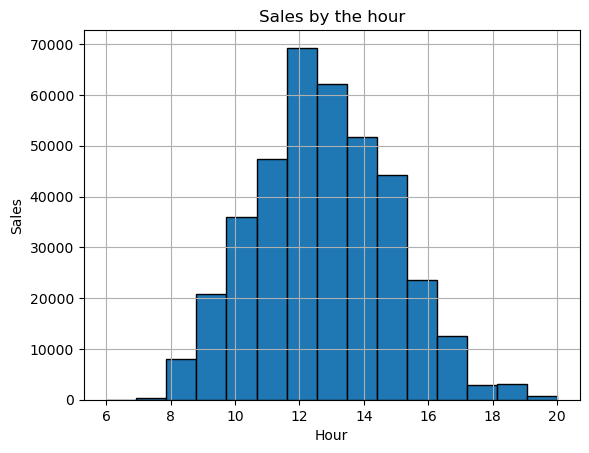

In [6]:
#Visualize the number of sales every 2 hours
df_cleaned['Hour'] = df_cleaned['Date'].dt.hour
df_cleaned['Hour'].hist(bins = 15, edgecolor = 'black')
plt.title("Sales by the hour")
plt.xlabel("Hour")
plt.ylabel("Sales")
plt.show()
df_cleaned.drop(columns = ["Hour"], inplace = True)

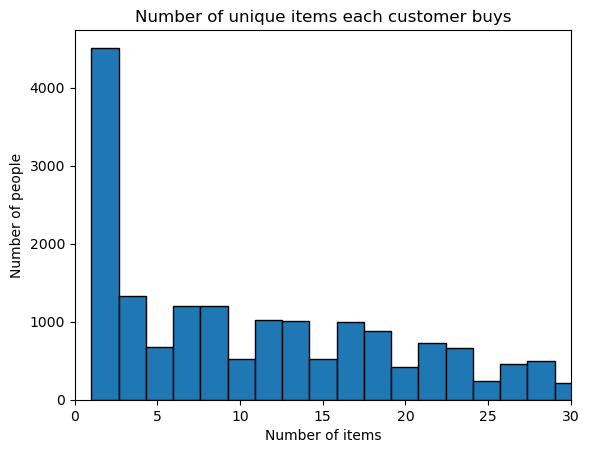

In [13]:
#Number of unique items every customer buys (in general)
bill_counts = df['BillNo'].value_counts() #count the number of times each unique billNo occurs
fig, ax = plt.subplots()
ax.hist(bill_counts, bins = 'auto', edgecolor = 'black')
ax.set_xlim(0, 30) #to get rid of outliers in order to get a more suitable graph
ax.set_title("Number of unique items each customer buys")
ax.set_xlabel("Number of items")
ax.set_ylabel("Number of people")
plt.show()

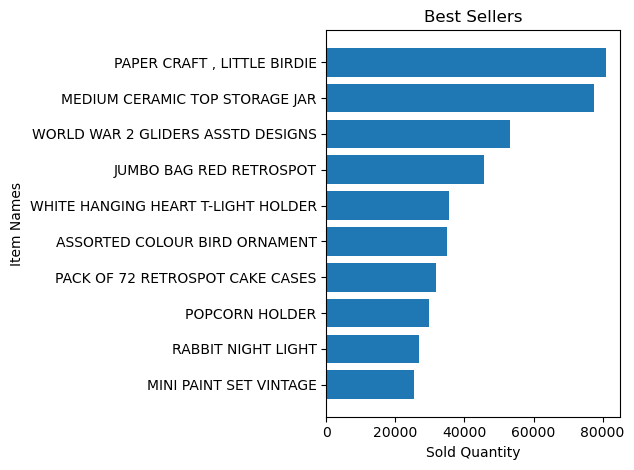

In [14]:
#Best Sellers
summed = df_cleaned.groupby('Itemname')['Quantity'].sum().reset_index()
summed = summed.nlargest(10, 'Quantity')
fig3, ax3 = plt.subplots()
ax3.barh(summed['Itemname'], summed['Quantity'])
ax3.set_title('Best Sellers')
ax3.set_xlabel('Sold Quantity')
ax3.set_ylabel('Item Names')
#Items should appear top to bottom on y-axis according to sales
ax3.invert_yaxis()
plt.tight_layout()
plt.show()

In [15]:
#We just need to run the following cell once, after that the csv file can be loaded and used

In [16]:
#Convert the dataset into a transaction dataset(matrix), meaning every row represents a transaction
# dummies = pd.get_dummies(df_cleaned['Itemname'])
# transactions = pd.concat([df_cleaned['BillNo'], dummies], axis = 1)
# transactions = transactions.groupby('BillNo').sum()
# transactions = transactions.clip(upper = 1)
# transactions = transactions.reset_index()
# transactions.drop(columns = ['BillNo'], inplace = True)
# transactions.to_csv('market_basket.csv', index = False)

In [17]:
#Create item sets with a support of at least 0.01
itemsets = pd.read_csv('market_basket.csv')
itemsets = itemsets.astype(bool)
freq_items = apriori(itemsets, min_support = 0.01, use_colnames = True)
num_itemsets = len(freq_items)
print('frequent items sets: \n', freq_items)

frequent items sets: 
       support                                           itemsets
0    0.013049                           (10 COLOUR SPACEBOY PEN)
1    0.010130                  (12 MESSAGE CARDS WITH ENVELOPES)
2    0.015086                    (12 PENCIL SMALL TUBE WOODLAND)
3    0.016792              (12 PENCILS SMALL TUBE RED RETROSPOT)
4    0.015911                      (12 PENCILS SMALL TUBE SKULL)
..        ...                                                ...
963  0.014040  (LUNCH BAG RED RETROSPOT, LUNCH BAG WOODLAND, ...
964  0.012113  (LUNCH BAG RED RETROSPOT, LUNCH BAG SUKI DESIG...
965  0.013379  (ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...
966  0.012002  (ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...
967  0.010461  (LUNCH BAG PINK POLKADOT, LUNCH BAG  BLACK SKU...

[968 rows x 2 columns]


In [19]:
#Create association rules using the item sets created above
rules = association_rules(freq_items, metric = 'confidence', min_threshold = 0.8,
                          num_itemsets = num_itemsets)
rules.sort_values(by = 'confidence', ascending = False, inplace = True)
print('Association rules: \n', rules)

Association rules: 
                                           antecedents  \
12  (PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...   
9   (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...   
13  (PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...   
7   (PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...   
3                      (POPPY'S PLAYHOUSE LIVINGROOM)   
11  (PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...   
4                           (REGENCY TEA PLATE GREEN)   
8   (PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...   
5                       (SET/6 RED SPOTTY PAPER CUPS)   
10  (GREEN REGENCY TEACUP AND SAUCER, REGENCY CAKE...   
0                    (PINK REGENCY TEACUP AND SAUCER)   
6                (WOODEN TREE CHRISTMAS SCANDINAVIAN)   
2                      (POPPY'S PLAYHOUSE LIVINGROOM)   
1                         (POPPY'S PLAYHOUSE BEDROOM)   

                             consequents  antecedent support  \
12     (GREEN REGENCY TEACUP AND SAUCER)            0.01337

In [20]:
#Top 10 rules according to confidence:

top_10 = rules.head(10)
print('Top 10 rules: \n', top_10)

Top 10 rules: 
                                           antecedents  \
12  (PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...   
9   (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...   
13  (PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...   
7   (PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...   
3                      (POPPY'S PLAYHOUSE LIVINGROOM)   
11  (PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...   
4                           (REGENCY TEA PLATE GREEN)   
8   (PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...   
5                       (SET/6 RED SPOTTY PAPER CUPS)   
10  (GREEN REGENCY TEACUP AND SAUCER, REGENCY CAKE...   

                          consequents  antecedent support  consequent support  \
12  (GREEN REGENCY TEACUP AND SAUCER)            0.013379            0.035952   
9   (GREEN REGENCY TEACUP AND SAUCER)            0.022408            0.035952   
13  (ROSES REGENCY TEACUP AND SAUCER)            0.013764            0.040412   
7   (GREEN REGENCY TEACUP AND SA

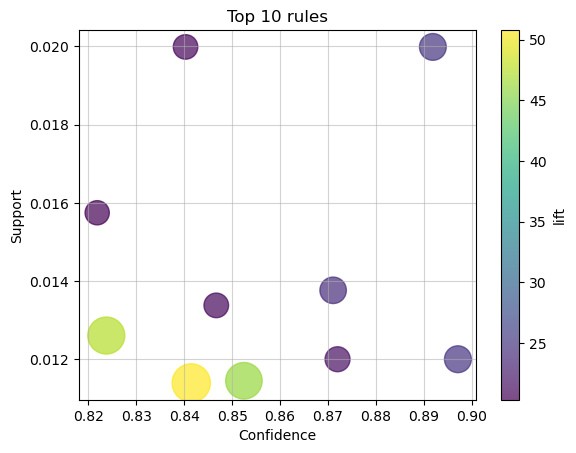

In [21]:
#Visualization:

#Scatter Plot:
fig4, ax4 = plt.subplots()
#s and c are size and color depending how big the lift value is; viridis is the colormap and 
#transparency is 0.7
scatter = ax4.scatter(top_10['confidence'], top_10['support'], s = (top_10['lift'] * 15),
                      c = top_10['lift'], cmap = 'viridis', alpha = 0.7)
ax4.set_xlabel('Confidence')
ax4.set_ylabel('Support')
ax4.set_title('Top 10 rules')
#show a colorbar
plt.colorbar(scatter, ax = ax4, label = 'lift')
#add grid lines for visibility
plt.grid(alpha = 0.55)
plt.show()

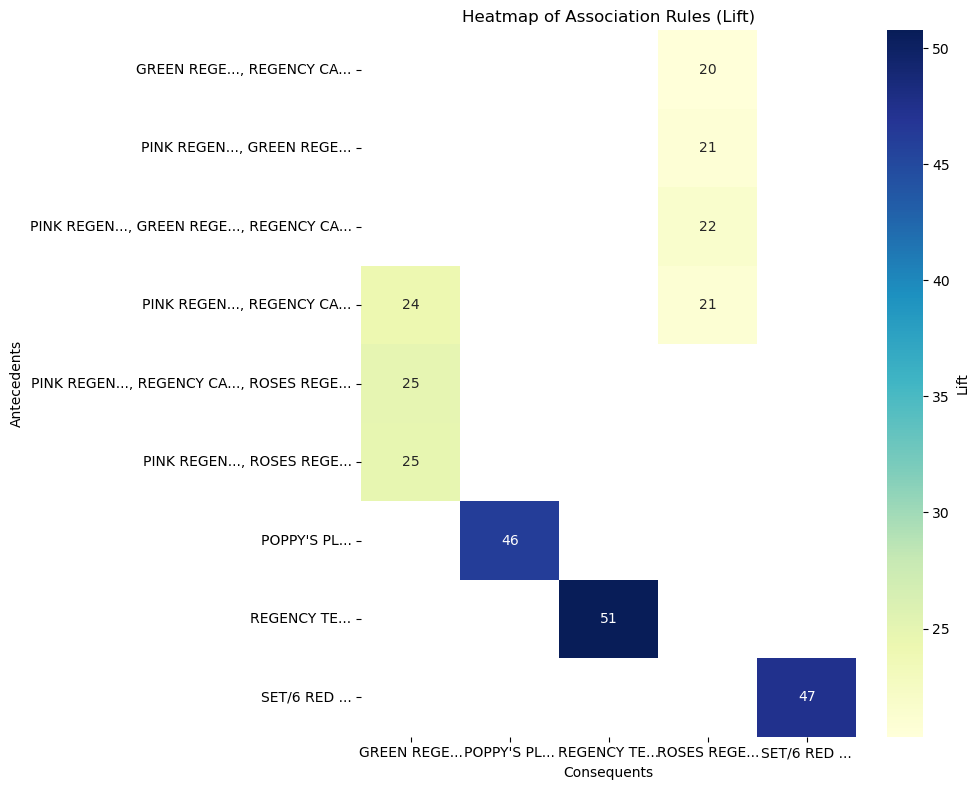

In [22]:
#HeatMap:
def shorten_labels(frozenset_items):
    short_labels = []
    for item in frozenset_items:
        short_labels.append(str(item)[:10] + '...')  
    return ', '.join(short_labels) 

rules['antecedents_short'] = rules['antecedents'].apply(shorten_labels)
rules['consequents_short'] = rules['consequents'].apply(shorten_labels)

heatmap_data = rules.head(10).pivot(index = 'antecedents_short', columns = 'consequents_short', values = 'lift')
plt.figure(figsize = (10, 8) )
sns.heatmap(heatmap_data, annot = True, cmap = "YlGnBu", cbar_kws = {'label': 'Lift'})
plt.title("Heatmap of Association Rules (Lift)")
plt.xlabel("Consequents")
plt.ylabel("Antecedents")
plt.xticks(rotation = 0)
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()

In [23]:
#Complete label names for the shortened ones used in the heatmap above are shown below:
columns_to_print = ['antecedents', 'antecedents_short', 'consequents', 'consequents_short']
print(rules[columns_to_print].head(10))


                                          antecedents  \
12  (PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...   
9   (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...   
13  (PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...   
7   (PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...   
3                      (POPPY'S PLAYHOUSE LIVINGROOM)   
11  (PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...   
4                           (REGENCY TEA PLATE GREEN)   
8   (PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...   
5                       (SET/6 RED SPOTTY PAPER CUPS)   
10  (GREEN REGENCY TEACUP AND SAUCER, REGENCY CAKE...   

                              antecedents_short  \
12  PINK REGEN..., REGENCY CA..., ROSES REGE...   
9                  PINK REGEN..., ROSES REGE...   
13  PINK REGEN..., GREEN REGE..., REGENCY CA...   
7                  PINK REGEN..., REGENCY CA...   
3                                 POPPY'S PL...   
11                 PINK REGEN..., REGENCY CA...   
4              